In [1]:
from pyironflow import PyironFlow
import pyiron_nodes as pn
from dataclasses import dataclass, field
from semantikon.typing import u
from semantikon.converter import semantikon_class
from semantikon.converter import parse_input_args, parse_output_args, parse_metadata, meta_to_dict
import pmdco

In [2]:
pf = PyironFlow([])
pf.gui

In [3]:
wf_gui = pf.get_workflow()
wf_gui

In [4]:
from pyiron_workflow.node import Node
from pyiron_workflow import Workflow
from rdflib import Graph, Namespace, URIRef, BNode
from rdflib import Literal as rdfLit
import graphviz
from rdflib.namespace import RDF, RDFS
from typing import Callable
from dataclasses import is_dataclass

In [5]:
EX = Namespace("http://pyiron_instances.org/")
NS = Namespace("http://pyiron_classes.org/")

In [6]:
def parse_node(node_function: Callable, node_type, node_id: str, node_label:str, g: Graph):
    
    try:
        meta_to_dict(node_function)["plan_specification"]
    except:
        if node_type == "atomic":
            g.add((EX[node_id], RDF.type, pmdco.DigitalWorkflowAtomicNode().IRI))
            g.add((EX[node_id], RDFS.label, rdfLit(node_label)))
            g.add((pmdco.DigitalWorkflowAtomicNode().IRI, RDFS.label, rdfLit(pmdco.DigitalWorkflowAtomicNode.__name__)))

    try:
        meta_to_dict(node_function)["planned_process"]
    except:
        if node_type == "atomic":
            g.add((EX[node_id + ".process"], pmdco.Executes().IRI, EX[node_id]))
            g.add((EX[node_id + ".process"], RDFS.label, rdfLit(node_label + ".process")))
            g.add((EX[node_id + ".process"], RDF.type, pmdco.DigitalWorkflowAtomicProcess().IRI))
            g.add((pmdco.DigitalWorkflowAtomicProcess().IRI, RDFS.label, rdfLit(pmdco.DigitalWorkflowAtomicProcess.__name__)))

    try:
        meta_to_dict(node_function)["plan"]
    except:
        if node_type == "atomic":
            g.add((EX[node_id + ".process"], pmdco.Realizes().IRI, EX[node_id + ".plan"]))
            g.add((EX[node_label + "Software1"], pmdco.IsAbout().IRI, EX[node_id + ".plan"]))
            g.add((pmdco.Realizes().IRI, RDFS.label, rdfLit(pmdco.Realizes.__name__)))
            g.add((pmdco.IsAbout().IRI, RDFS.label, rdfLit(pmdco.IsAbout.__name__)))
            g.add((EX[node_id + ".plan"], RDFS.label, rdfLit(node_label + ".plan")))
            g.add((EX[node_id + ".plan"], RDF.type, pmdco.DigitalWorkflowAtomicPlan().IRI))
            g.add((pmdco.DigitalWorkflowAtomicPlan().IRI, RDFS.label, rdfLit(pmdco.DigitalWorkflowAtomicPlan.__name__)))

    
    return g

In [7]:
def add_software(node_function: Callable, node_type, node_id: str, node_label:str, g: Graph):

    try:
        meta_to_dict(node_function)["software"]
    except:
        g.add((EX[node_id + ".process"], pmdco.Executes().IRI, EX[node_label + "Software1"]))
        g.add((pmdco.Executes().IRI, RDFS.label, rdfLit(pmdco.Executes.__name__)))
        g.add((EX[node_label + "Software1"], RDFS.label, rdfLit("standard-python-lib")))
        g.add((EX[node_label + "Software1"], RDF.type, pmdco.Software().IRI))
        g.add((pmdco.Software().IRI, RDFS.label, rdfLit(pmdco.Software.__name__)))

    try:
        meta_to_dict(node_function)["env"]
    except:
        g.add((EX[node_label + "Env1"], pmdco.HasContinuantPart().IRI, EX[node_label + "Software1"]))
        g.add((pmdco.HasContinuantPart().IRI, RDFS.label, rdfLit(pmdco.HasContinuantPart.__name__)))
        g.add((EX[node_label + "Env1"], RDFS.label, rdfLit("custom_env")))
        g.add((EX[node_label + "Env1"], RDF.type, pmdco.SoftwareEnv().IRI))
        g.add((pmdco.SoftwareEnv().IRI, RDFS.label, rdfLit(pmdco.SoftwareEnv.__name__)))
        
    return

In [8]:
def parse_input_ports(node_function: Callable, node_type, node_id: str, node_label:str, g: Graph):

    for k,v in parse_input_args(node_function).items():
        try:
            (v['role'])
        except:
            g.add((EX[node_id + ".process"], pmdco.Realizes().IRI, EX[node_id + "." + k]))
            g.add((pmdco.Realizes().IRI, RDFS.label, rdfLit(pmdco.Realizes.__name__)))
            g.add((EX[node_id + "." + k], RDF.type, pmdco.NodeInputPortRole().IRI))
            g.add((EX[node_id + "." + k], RDFS.label, rdfLit(node_label + "." + k)))
            g.add((pmdco.NodeInputPortRole().IRI, RDFS.label, rdfLit(pmdco.NodeInputPortRole.__name__)))

def parse_input_objects(node_function: Callable, node_type, node_id: str, node_label:str, g: Graph):

    for k,v in parse_input_args(node_function).items():
        try:
            (v['has_specified_input'])
        except:
            try:
                if is_dataclass(v["dtype"]):
                    parse_dataclass_object(v["dtype"](), node_id, node_label, k, g)
                    g.add((EX[node_id + ".process"], pmdco.HasSpecifiedInput().IRI, EX[node_id + "." + k + ".obj"]))
                    g.add((EX[node_id + "." + k + ".obj"], pmdco.IsConcretizedBy().IRI, EX[node_id + "." + k]))
                    g.add((pmdco.HasSpecifiedInput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedInput.__name__)))
                else:
                    parse_simple_object(node_id, node_label, k, g)
                    g.add((EX[node_id + ".process"], pmdco.HasSpecifiedInput().IRI, EX[node_id + "." + k + ".obj"]))
                    g.add((pmdco.HasSpecifiedInput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedInput.__name__)))
            except:
                parse_simple_object(node_id, node_label, k, g)
                g.add((EX[node_id + ".process"], pmdco.HasSpecifiedInput().IRI, EX[node_id + "." + k + ".obj"]))
                g.add((pmdco.HasSpecifiedInput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedInput.__name__)))
            
    return

In [9]:
def parse_output_ports_and_objects(node_function: Callable, node_type, node_id: str, node_label:str, g: Graph):
                
    if isinstance(parse_output_args(node_function), tuple):
        for idx, i in enumerate(parse_output_args(node_function)):
            try:
                (i['role'])
            except:
                g.add((EX[node_id + ".process"], pmdco.Realizes().IRI, EX[node_id + ".out." + str(idx)]))
                g.add((EX[node_id + ".out." + str(idx)], RDF.type, pmdco.NodeOutputPortRole().IRI))
                g.add((EX[node_id + ".out." + str(idx)], RDFS.label, rdfLit(node_label + "." + str(idx))))
                g.add((pmdco.NodeOutputPortRole().IRI, RDFS.label, rdfLit(pmdco.NodeOutputPortRole.__name__)))

            try:
                (i['has_specified_output'])
            except:
                try:
                    if is_dataclass(i["dtype"]):
                        parse_dataclass_object(i["dtype"](), node_id  + ".out", node_label, str(idx), g)
                        g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + str(idx) + ".obj"]))
                        g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
                    else:
                        parse_simple_object(node_id  + ".out", node_label, str(idx), g)
                        g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + str(idx) + ".obj"]))
                        g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
                except:
                    parse_simple_object(node_id  + ".out", node_label, str(idx), g)
                    g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + str(idx) + ".obj"]))
                    g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
    else:
        for idx, i in enumerate(parse_output_args(node_function)):
            try:
                parse_output_args(node_function)['role']
            except:
                g.add((EX[node_id + ".process"], pmdco.Realizes().IRI, EX[node_id + ".out." + str(idx)]))
                g.add((EX[node_id + ".out." + str(idx)], RDF.type, pmdco.NodeOutputPortRole().IRI))
                g.add((EX[node_id + ".out." + str(idx)], RDFS.label, rdfLit(node_label + "." + str(idx))))
                g.add((pmdco.NodeOutputPortRole().IRI, RDFS.label, rdfLit(pmdco.NodeOutputPortRole.__name__)))

            try:
                parse_output_args(node_function)['has_specified_output']
            except:
                try:
                    if is_dataclass(parse_output_args(node_function)["dtype"]):
                        parse_dataclass_object(parse_output_args(node_function)["dtype"](), node_id  + ".out", node_label, str(idx), g)
                        g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + str(idx) + ".obj"]))
                        g.add((EX[node_id + ".out" + "." + str(idx) + ".obj"], pmdco.IsConcretizedBy().IRI, EX[node_id + ".out." + str(idx)]))
                        g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
                    else:
                        parse_simple_object(node_id  + ".out", node_label, str(idx), g)
                        g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + str(idx) + ".obj"]))
                        g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
                except:
                    parse_simple_object(node_id  + ".out", node_label, str(idx), g)
                    g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + str(idx) + ".obj"]))
                    g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
            
    return

In [34]:
def make_connections(node: Node, wf_id, node_ids, g: Graph):
    print(node_ids)
    for idx, i in enumerate(node.outputs):
        for c in i.connections:
            g.add((EX[node_ids[c.owner.label] + ".process"], pmdco.HasSpecifiedInput().IRI, EX[node_ids[i.owner.label] + ".out" + "." + str(idx) + ".obj"]))
            g.add((EX[node_ids[i.owner.label] + ".out" + "." + str(idx) + ".obj"], pmdco.IsConcretizedBy().IRI, EX[node_ids[c.owner.label] + "." + c.label]))
    return

In [35]:
def parse_dataclass_object(dataclass, indent_id, upper_indent_label, upper_indent_field_name, g: Graph):

    from dataclasses import is_dataclass
    
    try:
        dataclass.__class__._semantikon_metadata
    except:
        g.add((EX[indent_id + "." + upper_indent_field_name + ".obj"], RDF.type, pmdco.ValueSpecification().IRI))
        g.add((EX[indent_id + "." + upper_indent_field_name + ".obj"], RDFS.label, rdfLit(upper_indent_label + "." + upper_indent_field_name + ".obj")))

    for field in fields(asd):
        try:
            meta_to_dict(field.type)["dtype"]
            if is_dataclass(meta_to_dict(field.type)["dtype"]):
                parse_dataclass_object(meta_to_dict(field.type)["dtype"](), "assd", "asd", field.name, g)
            else:
                parse_simple_field(indent_id + "." + upper_indent_field_name, upper_indent_label + "." + upper_indent_field_name, field.name, g)
        except:
            parse_simple_field("asd", "asd", field.name, g)
    return

In [36]:
def parse_simple_object(node_id, node_label, port, g: Graph):
    g.add((EX[node_id + "." + port + ".obj"], pmdco.IsConcretizedBy().IRI, EX[node_id + "." + port]))
    g.add((pmdco.IsConcretizedBy().IRI, RDFS.label, rdfLit(pmdco.IsConcretizedBy.__name__)))
    g.add((pmdco.HasSpecifiedInput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedInput.__name__)))
    g.add((EX[node_id + "." + port + ".obj"], RDF.type, pmdco.ValueSpecification().IRI))
    g.add((EX[node_id + "." + port + ".obj"], RDFS.label, rdfLit(node_label + "." + port + ".obj")))
    g.add((pmdco.ValueSpecification().IRI, RDFS.label, rdfLit(pmdco.ValueSpecification.__name__)))
    return

In [37]:
def parse_simple_field(indent_id, upper_indent_label, upper_indent_field_name, g: Graph):
    g.add((EX[indent_id + ".obj"], pmdco.HasContinuantPart().IRI, EX[indent_id + "." + upper_indent_field_name]))
    g.add((pmdco.HasContinuantPart().IRI, RDFS.label, rdfLit(pmdco.HasContinuantPart.__name__)))
    g.add((EX[indent_id + "." + upper_indent_field_name], RDF.type, pmdco.ValueSpecification().IRI))
    g.add((EX[indent_id + "." + upper_indent_field_name], RDFS.label, rdfLit(upper_indent_label + "." + upper_indent_field_name + ".obj")))
    return

In [38]:
def parse_node_execution(node: Node, g: Graph):
    return

In [39]:
def parse_workflow_execution(wf: Workflow, g: Graph):
    return

In [45]:
def parse_worklow_recipe(wf: Workflow):
    
    from pyiron_workflow.nodes.function import Function
    from pyiron_workflow.nodes.composite import Composite
    from pyiron_workflow.channels import NotData
    from dataclasses import is_dataclass
    import random
    
    g = Graph()
    wf_label = wf.label
    wf_id = str(id(wf_gui) * random.randint(10000,99999) + random.randint(10000,99999))[-16:]

    n_ids = {}
    for k,v in wf_gui.children.items():
        n_label = v.label
        n_id = wf_id + "." + str(id(v) * random.randint(10000,99999) + random.randint(10000,99999))[-16:]
        n_fn = v.node_function
        n_ids[n_label] = n_id

        if isinstance(v, Function):
            n_tp = "atomic"
        elif isinstance(v, Composite):
            n_tp = "workflow"
        else:
            continue

        parse_node(n_fn, n_tp, n_id, n_label, g)
        add_software(n_fn, n_tp, n_id, n_label, g)
        parse_input_ports(n_fn, n_tp, n_id, n_label, g)
        parse_output_ports_and_objects(n_fn, n_tp, n_id, n_label, g)

    for k,v in wf_gui.children.items():
        make_connections(v, wf_id, n_ids, g)
    
    return g, wf_id, n_ids

In [48]:
g, workflow_id, node_ids = parse_worklow_recipe(wf_gui)
for subj, pred, obj in g:
    print(subj, pred, obj)

{'SentenceSplitter': '1687705398610692.0357674065260872', 'WordsCombiner': '1687705398610692.7315799858398838'}
{'SentenceSplitter': '1687705398610692.0357674065260872', 'WordsCombiner': '1687705398610692.7315799858398838'}
http://purl.obolibrary.org/obo/BFO_0000055 http://www.w3.org/2000/01/rdf-schema#label Realizes
http://pyiron_instances.org/1687705398610692.0357674065260872.process http://purl.obolibrary.org/obo/BFO_0000055 http://pyiron_instances.org/1687705398610692.0357674065260872.sentence
http://pyiron_instances.org/1687705398610692.7315799858398838.out.0.obj http://purl.obolibrary.org/obo/BFO_0000058 http://pyiron_instances.org/1687705398610692.7315799858398838.out.0
http://pyiron_instances.org/1687705398610692.0357674065260872.out.0.obj http://purl.obolibrary.org/obo/BFO_0000058 http://pyiron_instances.org/1687705398610692.7315799858398838.last_word
http://pyiron_instances.org/1687705398610692.7315799858398838.last_word http://www.w3.org/2000/01/rdf-schema#label WordsCombine

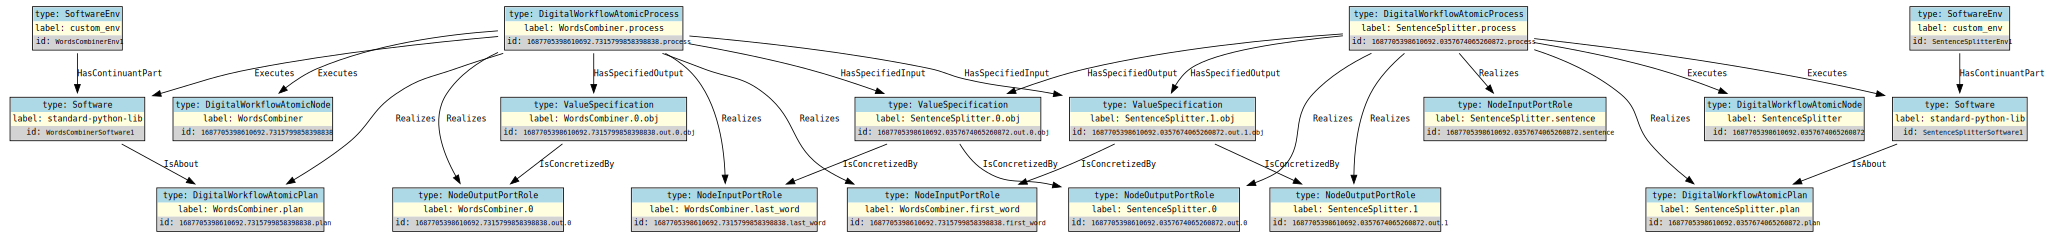

In [49]:
temp_visualize(g)

In [18]:
from IPython.display import SVG

def build_node_labels(g, instance_nodes):
    node_info = {}
    # Only collect info for instance nodes
    for s in instance_nodes:
        entry = node_info.setdefault(s, {})
        for p, o in g.predicate_objects(s):
            if p == RDFS.label:
                entry['label'] = str(o)
            elif p == RDF.value:
                entry['value'] = str(o)
            elif p == RDF.type:
                entry['type'] = o  # keep as URIRef for now
    # Look up type_label for each node with a type
    for entry in node_info.values():
        if 'type' in entry and isinstance(entry['type'], URIRef):
            type_label = None
            for lbl in g.objects(entry['type'], RDFS.label):
                type_label = str(lbl)
                break
            if type_label:
                entry['type_label'] = type_label
            else:
                entry['type_label'] = str(entry['type']).split('/')[-1].split('#')[-1]
            entry['type'] = str(entry['type'])
    return node_info

    # Second pass: for each node with type, try to find the label of the type
    for entry in node_info.values():
        if 'type' in entry and isinstance(entry['type'], URIRef):
            type_label = None
            for lbl in g.objects(entry['type'], RDFS.label):
                type_label = str(lbl)
                break
            if type_label:
                entry['type_label'] = type_label
            else:
                # fallback: use local part of type URI
                entry['type_label'] = str(entry['type']).split('/')[-1].split('#')[-1]
            entry['type'] = str(entry['type'])  # Optionally, keep string as well
    return node_info

def make_html_label(info, raw_id):
    label = "<"
    label += '<table BORDER="1" CELLBORDER="0" CELLSPACING="0">'
    # Add all fields, always center
    if 'type_label' in info:
        label += f'<tr><td ALIGN="CENTER" BGCOLOR="lightblue"><font point-size="10" face="monospace">type: {info["type_label"]}</font></td></tr>'
    if 'label' in info:
        label += f'<tr><td ALIGN="CENTER" BGCOLOR="lightyellow"><font point-size="10" face="monospace">label: {info["label"]}</font></td></tr>'
    label += f'<tr><td ALIGN="CENTER" BGCOLOR="lightgray"><font point-size="10" face="monospace">id: </font><font point-size="8" face="monospace">{raw_id}</font></td></tr>'
    if 'value' in info:
        label += f'<tr><td ALIGN="CENTER" BGCOLOR="white"><font point-size="10" face="monospace">value: {info["value"]}</font></td></tr>'
    label += "</table>>"
    return label

def get_property_label(graph, property_uri):
    for label in graph.objects(property_uri, RDFS.label):
        return str(label)
    # Fallback to local name
    s = str(property_uri)
    if '#' in s:
        return s.split('#')[-1]
    else:
        return s.rstrip('/').split('/')[-1]

def temp_visualize(g: Graph):
    dot = graphviz.Digraph('RDF_Graph', engine="dot")
    dot.attr(rankdir='TB')

    # Determine which nodes are instances:
    instance_nodes = set()
    for s, p, o in g:
        if not isinstance(s, URIRef):
            continue
        # If predicate is not rdfs:label and not rdf:type, it's "real" data
        if p != RDF.type and p != RDFS.label:
            instance_nodes.add(s)
    # Also include any node that's the subject of rdf:type (otherwise, type-only nodes vanish from labels)
    for s, p, o in g.triples((None, RDF.type, None)):
        instance_nodes.add(s)

    node_labels = build_node_labels(g, instance_nodes)
    node_ids = {n: str(n).split('/')[-1] for n in node_labels.keys()}

    for node, info in node_labels.items():
        raw_id = node_ids[node]
        label = make_html_label(info, raw_id)
        dot.node(raw_id, label=label, shape='plaintext')

    # Edges only between these instance nodes
    for subj, pred, obj in g:
        if pred == RDF.type:
            continue
        if not (isinstance(subj, URIRef) and isinstance(obj, URIRef)):
            continue
        if subj not in node_labels or obj not in node_labels:
            continue
        subj_id = node_ids[subj]
        obj_id = node_ids[obj]
        pred_label = get_property_label(g, pred)
        dot.edge(subj_id, obj_id, label=pred_label, fontsize='10', fontname="monospace")

    display(SVG(dot.pipe(format='svg')))